## LSTM based simulation with Tensorflow v2.3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from datetime import timedelta
from tensorflow.python.framework import ops as tf_ops
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
from deeplearning.utils import WindowGenerator
sns.set()

### Define global variables

In [3]:
csv_filepath:str = "../../datasets/NSE/Quote-Equity-HDFC-EQ-29-08-2018-to-20-08-2020.csv"
print(f"csv_filepath {csv_filepath}")
date_column:str = "Date "
open_column:str = "OPEN "
high_column:str = "HIGH "
low_column:str = "LOW "
close_column:str = "close "
volume_column:str = "VOLUME "

csv_filepath ../../datasets/NSE/Quote-Equity-HDFC-EQ-29-08-2018-to-20-08-2020.csv


### Read csv data

In [4]:
df = pd.read_csv(csv_filepath, header=0)
print(f"df keys")
print(f"{df.keys()}")
# Sort DataFrame by date
df[date_column]=pd.to_datetime(df[date_column])
df.head()

df keys
Index(['Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ', 'PREV. CLOSE ', 'ltp ',
       'close ', 'vwap ', '52W H ', '52W L ', 'VOLUME ', 'VALUE ',
       'No of trades '],
      dtype='object')


,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,2020-08-19,EQ,"1,835.00","1,835.90","1,818.05","1,820.70","1,827.55","1,827.95","1,828.01","2,499.90","1,473.45",2934730,"5,364,712,976.60",85358
1,2020-08-18,EQ,"1,801.10","1,825.40","1,795.95","1,800.55","1,819.05","1,820.70","1,813.53","2,499.90","1,473.45",3413536,"6,190,549,505.40",141811
2,2020-08-17,EQ,"1,805.00","1,807.85","1,783.85","1,791.70","1,801.95","1,800.55","1,795.17","2,499.90","1,473.45",4076960,"7,318,829,944.15",148103
3,2020-08-14,EQ,"1,818.60","1,823.75","1,773.25","1,804.85","1,793.75","1,791.70","1,796.65","2,499.90","1,473.45",6136766,"11,025,637,096.85",186319
4,2020-08-13,EQ,"1,818.50","1,823.65","1,799.55","1,814.20","1,810.00","1,804.85","1,807.52","2,499.90","1,473.45",3769538,"6,813,503,042.60",129725


In [5]:
df[date_column] = pd.to_datetime(df[date_column]).astype('datetime64[ns]')
df[open_column] = df[open_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[high_column] = df[high_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[low_column] = df[low_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[close_column] = df[close_column].transform(func=lambda x: "".join(str(x).split(","))).astype(float)
df[volume_column] = df[volume_column].transform(func=lambda x: "".join(str(x).split(","))).astype(int)
df = df[[date_column, open_column, high_column, low_column, close_column, volume_column]]
df = df.sort_values(by=[date_column], ascending=True)
df.head()

,Date,OPEN,HIGH,LOW,close,VOLUME
485,2018-08-29,1959.4,1971.40,1944.70,1956.25,2367281
484,2018-08-30,1950.0,1964.45,1928.25,1934.15,2466442
483,2018-08-31,1940.9,1942.45,1908.05,1935.95,3856093
482,2018-09-03,1950.0,1950.00,1928.10,1944.80,2310201
481,2018-09-04,1939.0,1959.65,1939.00,1954.80,2928533


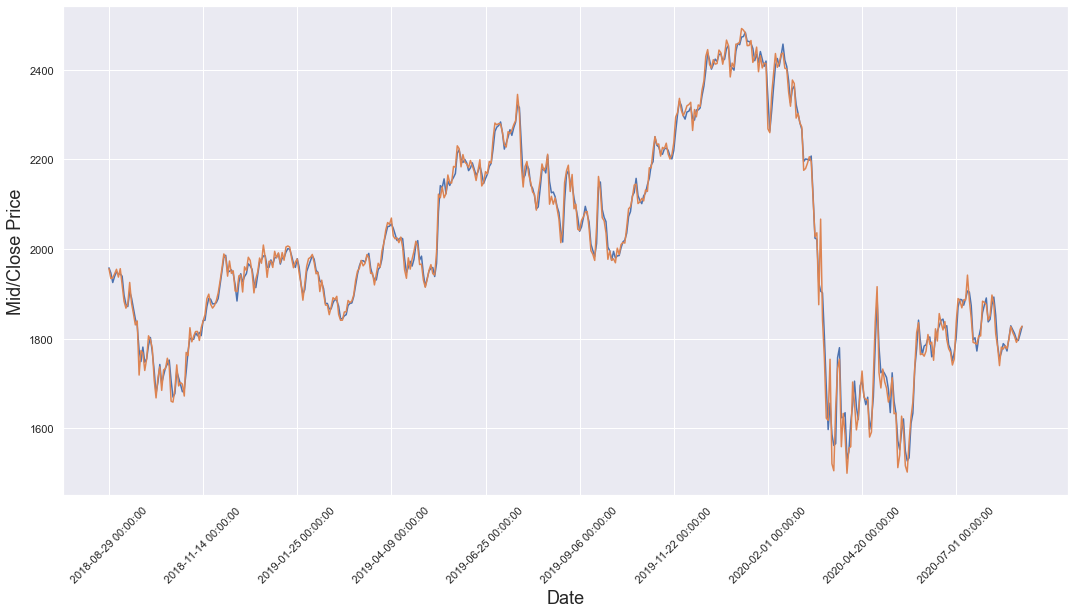

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df[low_column]+df[high_column])/2.0)
plt.plot(range(df.shape[0]),(df[close_column]))
plt.xticks(range(0,df.shape[0],50),df[date_column].loc[::50],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid/Close Price',fontsize=18)
plt.show()

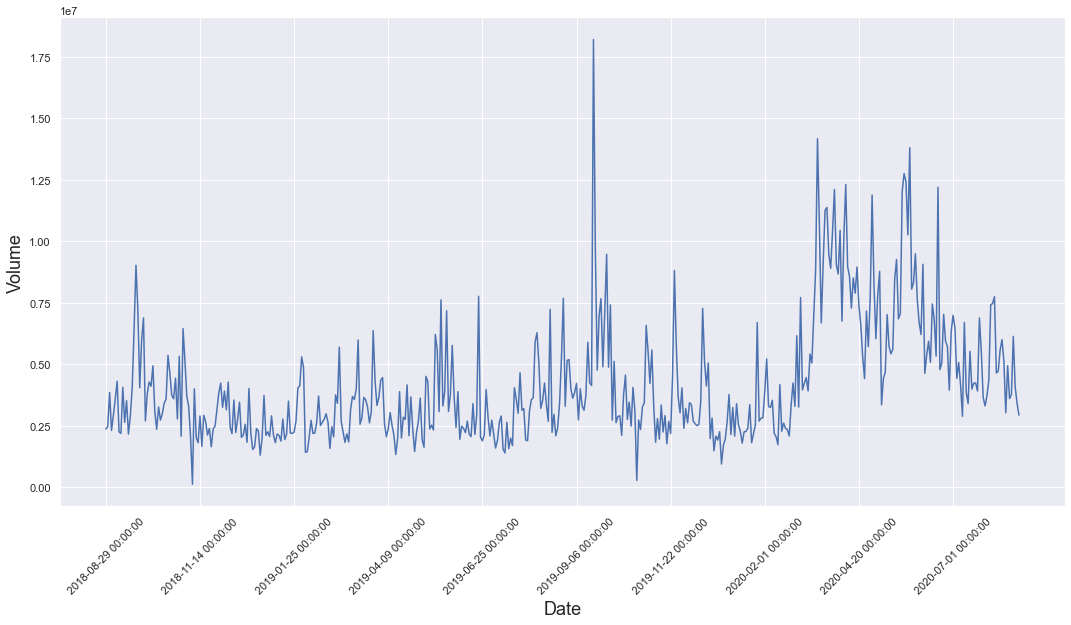

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df[volume_column]))
plt.xticks(range(0,df.shape[0],50),df[date_column].loc[::50],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Volume',fontsize=18)
plt.show()

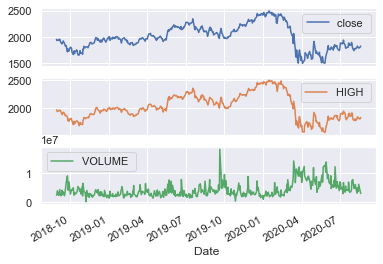

In [8]:
date_time = pd.to_datetime(df[date_column], format='%Y-%m-%d')

plot_cols = [close_column, high_column, volume_column]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

## Data inspection and cleanup

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
OPEN,486.0,2.004346e+03,2.291201e+02,1476.00,1837.500,1975.000,2179.725,2486.0
HIGH,486.0,2.029387e+03,2.234151e+02,1568.15,1860.075,1990.850,2196.500,2499.9
LOW,486.0,1.976023e+03,2.331954e+02,1473.45,1811.150,1951.650,2153.275,2471.8
close,486.0,2.002078e+03,2.304987e+02,1499.55,1835.925,1973.925,2178.675,2492.3
VOLUME,486.0,4.179665e+06,2.460386e+06,124505.00,2426419.500,3435599.500,5139375.250,18203636.0


## Split the data

We'll use a (70%, 25%, 15%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

    It ensures that chopping the data into windows of consecutive samples is still possible.
    It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.


In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

df = df.drop(columns=[date_column])
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.65):int(n*0.9)]
test_df = df[int(n*0.85):]

num_features = df.shape[1]
train_df.head()

,OPEN,HIGH,LOW,close,VOLUME
485,1959.4,1971.40,1944.70,1956.25,2367281
484,1950.0,1964.45,1928.25,1934.15,2466442
483,1940.9,1942.45,1908.05,1935.95,3856093
482,1950.0,1950.00,1928.10,1944.80,2310201
481,1939.0,1959.65,1939.00,1954.80,2928533


In [11]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages.

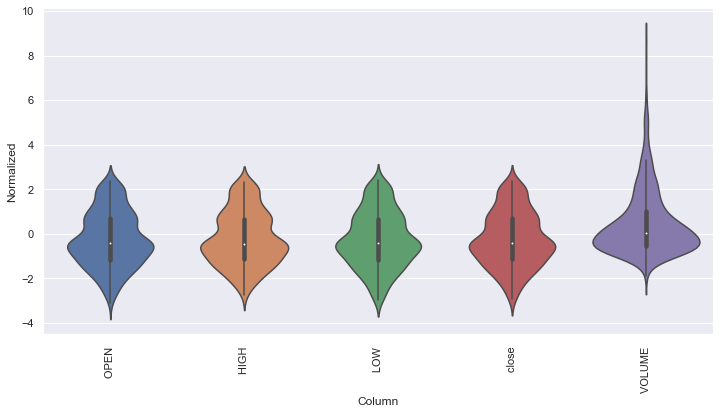

In [12]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [13]:
w2 = WindowGenerator(6, 1, 1, train_df, val_df, test_df, [close_column])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close ']

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
labels shape: (3, 1, 1)


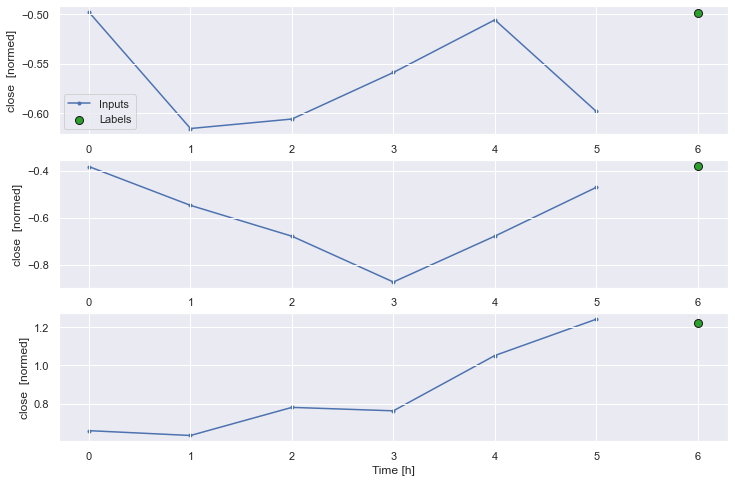

In [16]:
w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col=close_column, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

w2.plot()


In [17]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [19]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [20]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 5)
Labels shape (batch, time, features): (32, 1, 1)


In [21]:
single_step_window = WindowGenerator(1, 1, 1, train_df, val_df, test_df, [close_column])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close ']

In [22]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [23]:
baseline = Baseline(label_index=column_indices[close_column])

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = dict()
performance = dict()
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


4/4 [==============================] - 0s 796us/step - loss: 15.4612 - mean_absolute_error: 3.4210


In [24]:
wide_window = WindowGenerator(24, 24, 1, train_df, val_df, test_df, [close_column])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close ']

In [25]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


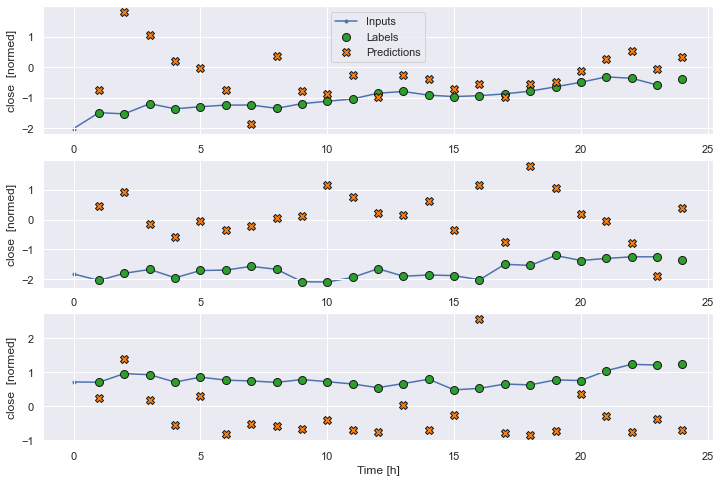

In [26]:
wide_window.plot(baseline)

In [27]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


In [28]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
11/11 [==============================] - 0s 17ms/step - loss: 1.5916 - mean_absolute_error: 0.9574 - val_loss: 2.5858 - val_mean_absolute_error: 1.3565
Epoch 2/20
11/11 [==============================] - 0s 9ms/step - loss: 1.5079 - mean_absolute_error: 0.9266 - val_loss: 2.5226 - val_mean_absolute_error: 1.3292
Epoch 3/20
11/11 [==============================] - 0s 8ms/step - loss: 1.4346 - mean_absolute_error: 0.8970 - val_loss: 2.4706 - val_mean_absolute_error: 1.3045
Epoch 4/20
11/11 [==============================] - 0s 11ms/step - loss: 1.3636 - mean_absolute_error: 0.8693 - val_loss: 2.4305 - val_mean_absolute_error: 1.2808
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1.2984 - mean_absolute_error: 0.8427 - val_loss: 2.4030 - val_mean_absolute_error: 1.2586
Epoch 6/20

In [29]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


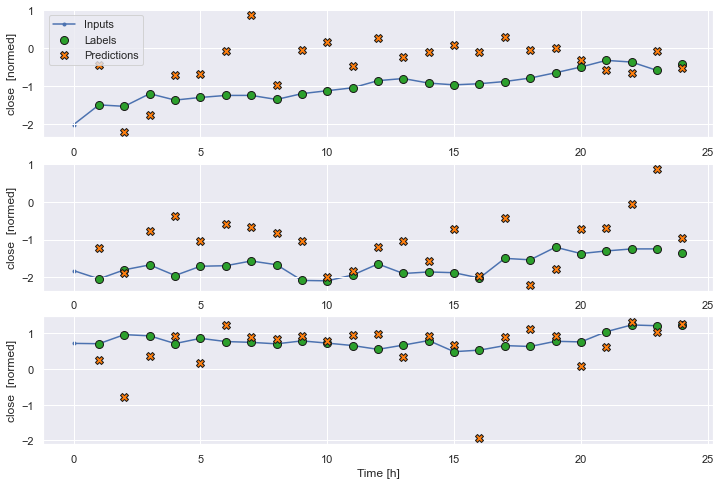

In [30]:
wide_window.plot(linear)
